### Download packages


In [18]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)

import scipy.integrate as integrate

In [19]:
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [20]:
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import numpy as np
import time

nb.__version__

'0.54.1'

### Define Numba code

In [21]:
# define the gradV function 
@njit(float64(float64))
def dU(x):
    """
    Compute the potential of the infinite double well:
    x: float 
    """

    return -1/(x*x*x)+2*x

@njit(float64(float64,float64,float64,float64))
def e_m_fast(y0,s,b1,dt):
    """
    The Euler-Maruyama scheme applied to the infinite double well
    y0: float
        value of y at t_n
    tau: float
        value of the temperature 
    b1: float
        brownian increment 
    dt: float
        time increment
    """
    y1=y0 - dU(y0)*dt+s*b1
    return y1    
    

    
@njit(float64(float64,float64,float64,float64))
def run_num(y0,s,dt,N):
    """
    Run the simulation for one sample path
    Input
    -----
    N: int
        Number of steps taken in T=1 sec
    dt: float 
        Value of time increment. Is 1/N.
    s: float 
        Is sqrt(2 \tau). 
    T: int
        Final time
    Return
    ------
    yf: float
        Value of X(T) as approximated by the numerical scheme chosen
        
    """
    for ii in range(N):
        b1 = np.random.normal(0,1,1)[0]
        y1 = e_m_fast(y0,s,b1,dt)
        y0=y1 
    return y1



@njit() #float64[:](float64,float64,float64,float64))
def DW_sde_fast(T,dt,tau): # Function is compiled and runs in machine code
    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        Final time
    N: int
        Number of time steps 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    method: function
        Numerical scheme used for the DW SDE
    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """
    N = int(1/dt)   #size of the time steps
    y_final = [] #np.zeros(n_samples)
    s = np.sqrt(2*tau*dt)
    n_esc=0
    y0 = 1
    for jj in range(T): # Run until T= Tsec
        y1=run_num(y0,s,dt,N)
        y0=y1
        y_final.append(y1)
    y_final=np.array(y_final)
    return y_final

%time y_compile = DW_sde_fast(3,10**(-6),0.001) # compile the function


CPU times: user 475 ms, sys: 0 ns, total: 475 ms
Wall time: 475 ms


%time y_compile = DW_sde_fast(10000,3,1000,0.001) # compile the function

CPU times: user 53.3 s, sys: 31.9 ms, total: 53.4 s
Wall time: 4.63 s

<!-- ### Analysing time and design of the function : 
y_compile = DW_sde_fast(1000,3,100,0.001) # compile the function
%time y_compile = DW_sde_fast(1000,3,100,0.001) 

1) with run num sub
CPU times: user 506 ms, sys: 3.99 ms, total: 510 ms
Wall time: 46.2 ms
or CPU times: user 501 ms, sys: 0 ns, total: 501 ms
Wall time: 42.4 ms


2) without run num sub but double loop 
CPU times: user 508 ms, sys: 12 µs, total: 508 ms
Wall time: 45.9 ms
CPU times: user 491 ms, sys: 4.01 ms, total: 495 ms
Wall time: 45.7 ms


3) Without run num sub and only one loop 

CPU times: user 467 ms, sys: 0 ns, total: 467 ms
Wall time: 45.5 ms
     -->
     
No change between having a function run_num_sub and not having one or two loops or no loop -





### Define the invariant distribution

In [16]:
def U(x):
    """
    potential of -the infinite double well
    """

    return (1/(2*x**2)+x*x)

def pinf(x,tau):
    return np.exp(-U(x)/tau)


### Show how numerical simulations is different from histogram

We want to show how it is different the invariant distribution and we want to show how DT, tau and Tf impacts that. 

## ---------------- Different values of delta t or N ----------------

### \\tau=0.01

In [29]:
## Plot results on the simulation
T=10**6
tau=0.01
dt_list=[1,0.5,0.1,10**(-2),10**(-3),10**(-4),10**(-5)]
n_samples = 1000

# empty vector to save results
y_res = []
for i in range(len(dt_list)):
    dti=dt_list[i]
    y_exact = DW_sde_fast(T,dti,tau)
    y_res.append(y_exact)
    

KeyboardInterrupt: 

In [ ]:
y_res

/home/s2133976/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/s2133976/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


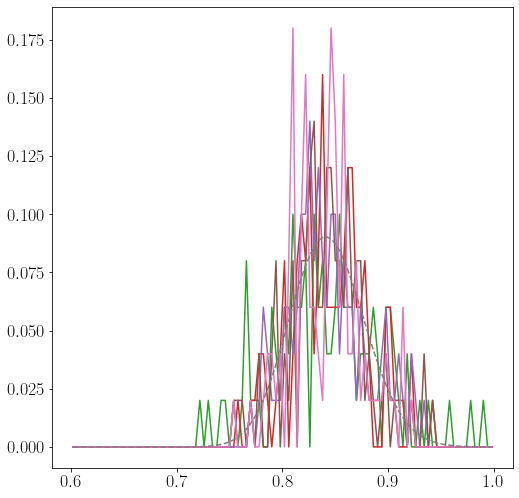

In [28]:
# axis of the plot 
fig, (ax)= plt.subplots(1, 1,figsize=(8,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


## Plot 1 
for i in range(len(dt_list)):
    ye = y_res[i]
    dti = dt_list[i]
    histogram,bins = np.histogram(ye,bins=100,range=[0.6,1], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    ax.plot(midx,histogram,label='$\Delta t=$'+str(dti))
    
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- (U(midx)/tau))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
rho=(rho/np.sum(rho))*2
ax.plot(midx,rho,'--',label='Truth')      
# axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# ax.set_ylim(0,0.125)



### $\\tau=1$

## ---------------- Different values of tau ----------------

In [46]:
tau_list = np.round(np.arange(0.001,0.2+d,),5)
tau_list


array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096, 0.101, 0.106, 0.111, 0.116, 0.121, 0.126, 0.131,
       0.136, 0.141, 0.146, 0.151, 0.156, 0.161, 0.166, 0.171, 0.176,
       0.181, 0.186, 0.191, 0.196, 0.201])

In [8]:
## Plot results on the simulation
n_samples = 10**3
T=10
dt=0.1
d = (0.02-0.001)/5
tau_list = np.round(np.arange(0.001,0.02+d,d),5)

# empty vector to save results
y_res_tau = np.zeros((len(tau_list),n_samples))

#run through the different values of tau 
for i in range(len(tau_list)):
    tau_i=tau_list[i]
    y_exact = DW_sde_fast(n_samples,T,dt,tau_i)
    y_res_tau[i,::]=y_exact
    

/tmp/ipykernel_3694/3258494148.py:23: RuntimeWarning: invalid value encountered in true_divide
  rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) )


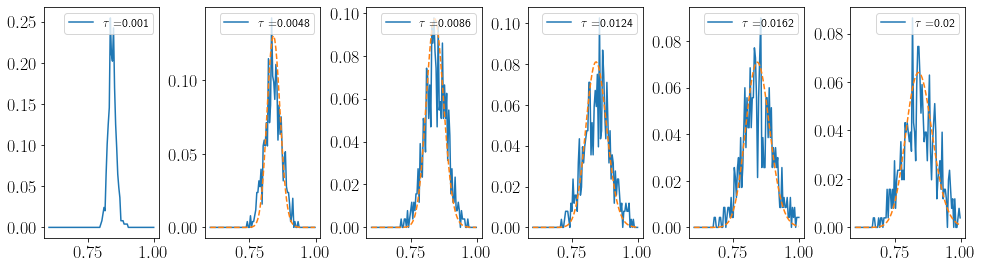

In [9]:
# axis of the plot 
fig, (axs)= plt.subplots(1, 6,figsize=(16,4))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


## Plot 1 
for i in range(len(tau_list)):
    ye = y_res_tau[i,::]
    tau_i = tau_list[i]
    histogram,bins = np.histogram(ye,bins=100,range=[0.6,1], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    axs[i].plot(midx,histogram,label='$\\tau =$'+str(tau_i))
    axs[i].legend() #add the legend

    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- (U(midx)/tau_i))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    axs[i].plot(midx,rho,'--',label='Truth')   
    
# # axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# # axs[0].set_ylim(0,0.125)

# ## Plot 2 
# for i in range(len(tau_list)):
#     ye = y_res_tau[i,::]
#     tau_i = tau_list[i]
#     histogram,bins = np.histogram(ye,bins=100,range=[-1,1], density=True)
#     midx = (bins[0:-1]+bins[1:])/2
#     histogram=histogram/np.sum(histogram)
#     axs[1,i].plot(midx,histogram,label='$\\tau =$'+str(tau_i))
    
# midx = (bins[0:-1]+bins[1:])/2
# rho = np.exp(- (U(midx)/tau))
# rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
# rho=rho/np.sum(rho)
# axs[1,5].plot(midx,rho,'--',label='Truth')      
# axs[1,5].legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# # axs[1].set_ylim(0,0.125)

## ---------------- Different values of Tf ----------------



In [25]:
## Plot results on the simulation
n_samples = 10**4
dt=10**(-3)
tau = 0.01
T_list = [0.2,0.5,1,5,10]

# empty vector to save results
y_resT = np.zeros((len(T_list),n_samples))

#run through the different values of tau 
for i in range(len(T_list)):
    T_i = T_list[i]
    y_exact = DW_sde_fast(n_samples,T_i,dt,tau)
    y_resT[i,::]=y_exact

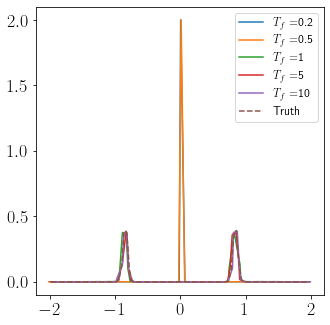

In [35]:
# axis of the plot 
fig, (axs)= plt.subplots(1, 1,figsize=(5,5))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


## Plot 1 
for i in range(len(T_list)):
    ye = y_resT[i,::]
    Ti = T_list[i]
    histogram,bins = np.histogram(ye,bins=100,range=[-2,2], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    midx = midx+np.random.normal(0,0.015,len(midx))
    histogram=(histogram/np.sum(histogram))*2
    axs.plot(midx,histogram,label='$T_f =$'+str(Ti))

midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- (U(midx)/tau))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
rho=(rho/np.sum(rho))*2
axs.plot(midx,rho,"--",label='Truth')   
axs.legend() #add the legend
